# Introduction to MLflow

Similar to W&B, MLflow also provides a python API that allows tracking of hyperparameters (log_param), evaluation metrics (log_metric), and artifacts (log_artifacts).

To install MLflow locally type: 
```bash
pip install mlflow
```
To start UI type:
```bash
mlflow ui
```
Now you open your webrowser and type or copy http address that is displayed in the row "Listening at: " 
```
[INFO] Listening at: http://127.0.0.1:5000
```
You should see MLflow UI

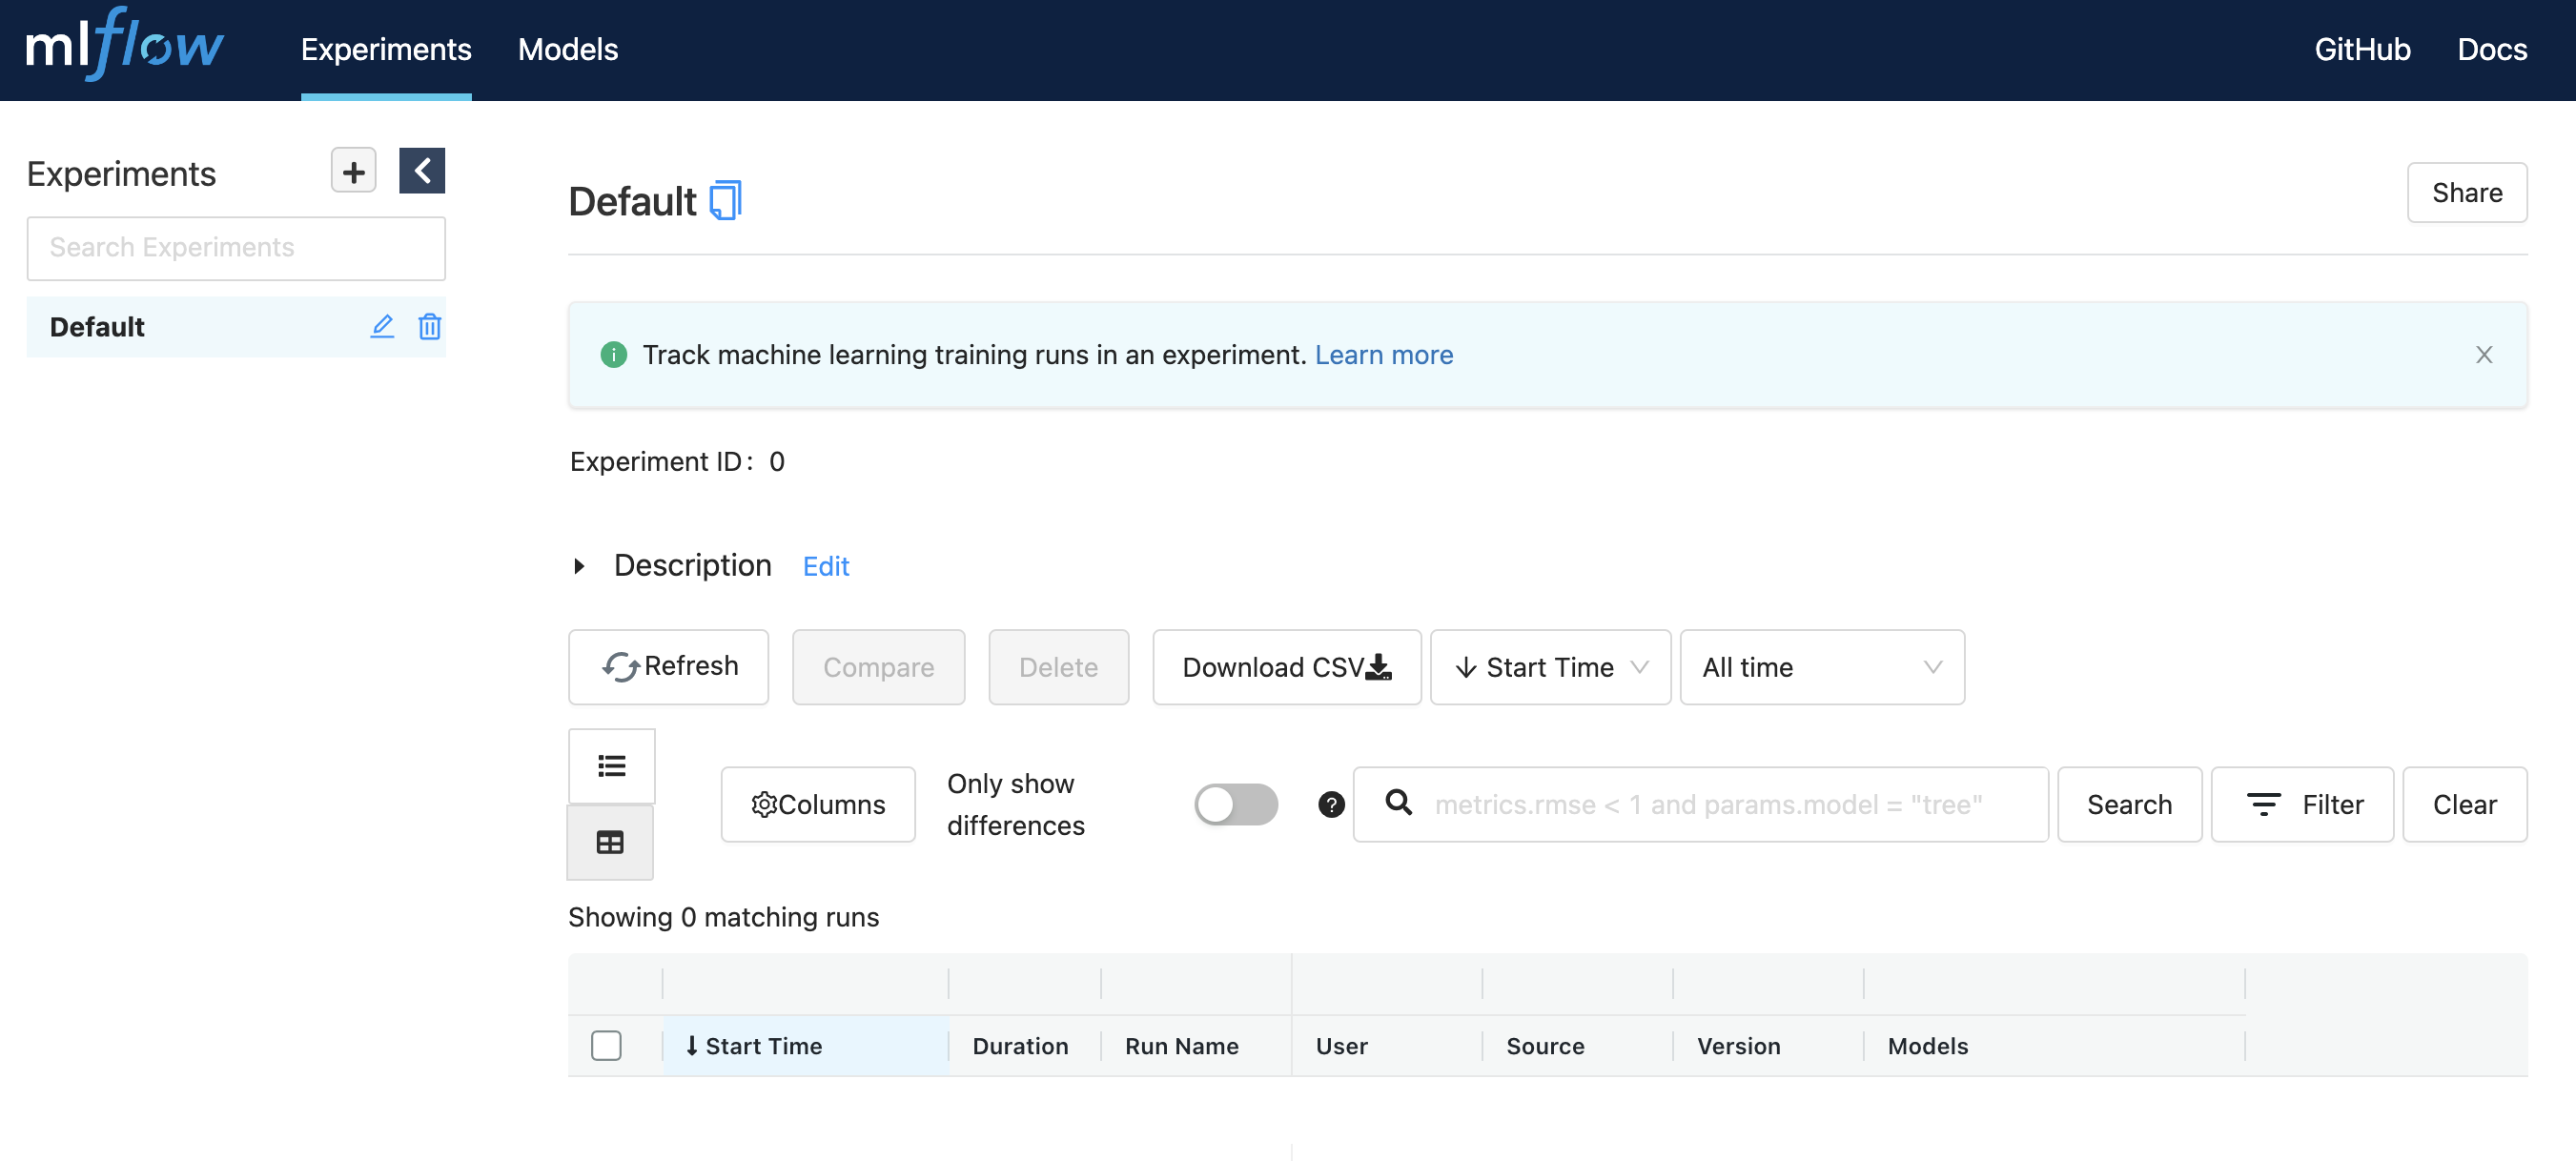

In [6]:
from IPython.display import Image
Image(filename='static/mlflow_ui.png') 

## Let's log some random metrics and a file artifact in our first run

In [4]:
import os
import mlflow
from mlflow import log_metric, log_param, log_artifacts

log_param("epochs", 30)
log_metric("custom", 0.6)

log_metric("custom", 0.75) # metrics can be updated
if not os.path.exists("artifact_dir"):
    os.makedirs("artifact_dir")

with open("artifact_dir/test.txt", "w") as f:
    f.write("simple example")
log_artifacts("artifact_dir")

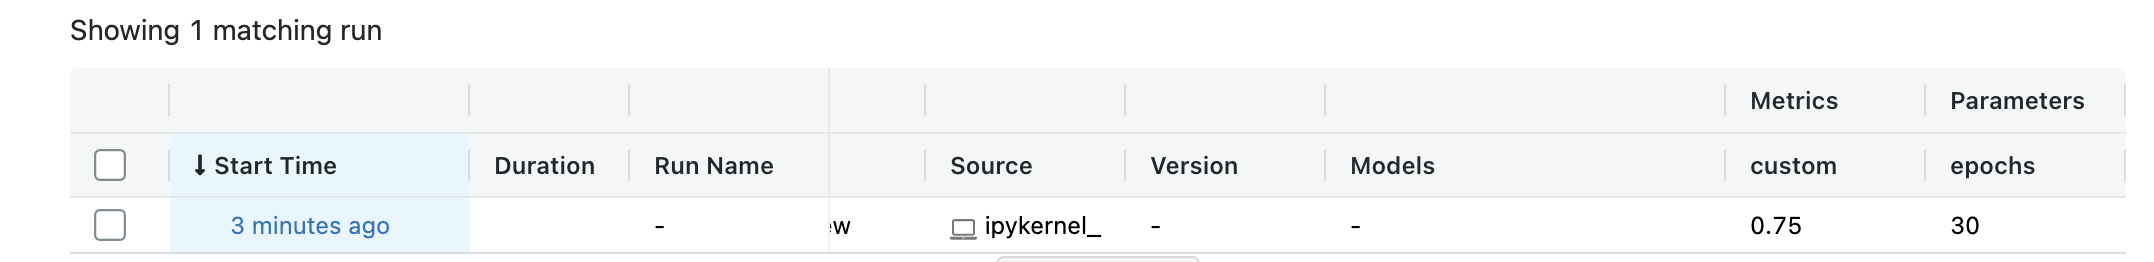

In [8]:
from IPython.display import Image
Image(filename='static/first_exp.png') 

 We can click on the experiment and check details. We will see that our artifact was also correctly saved

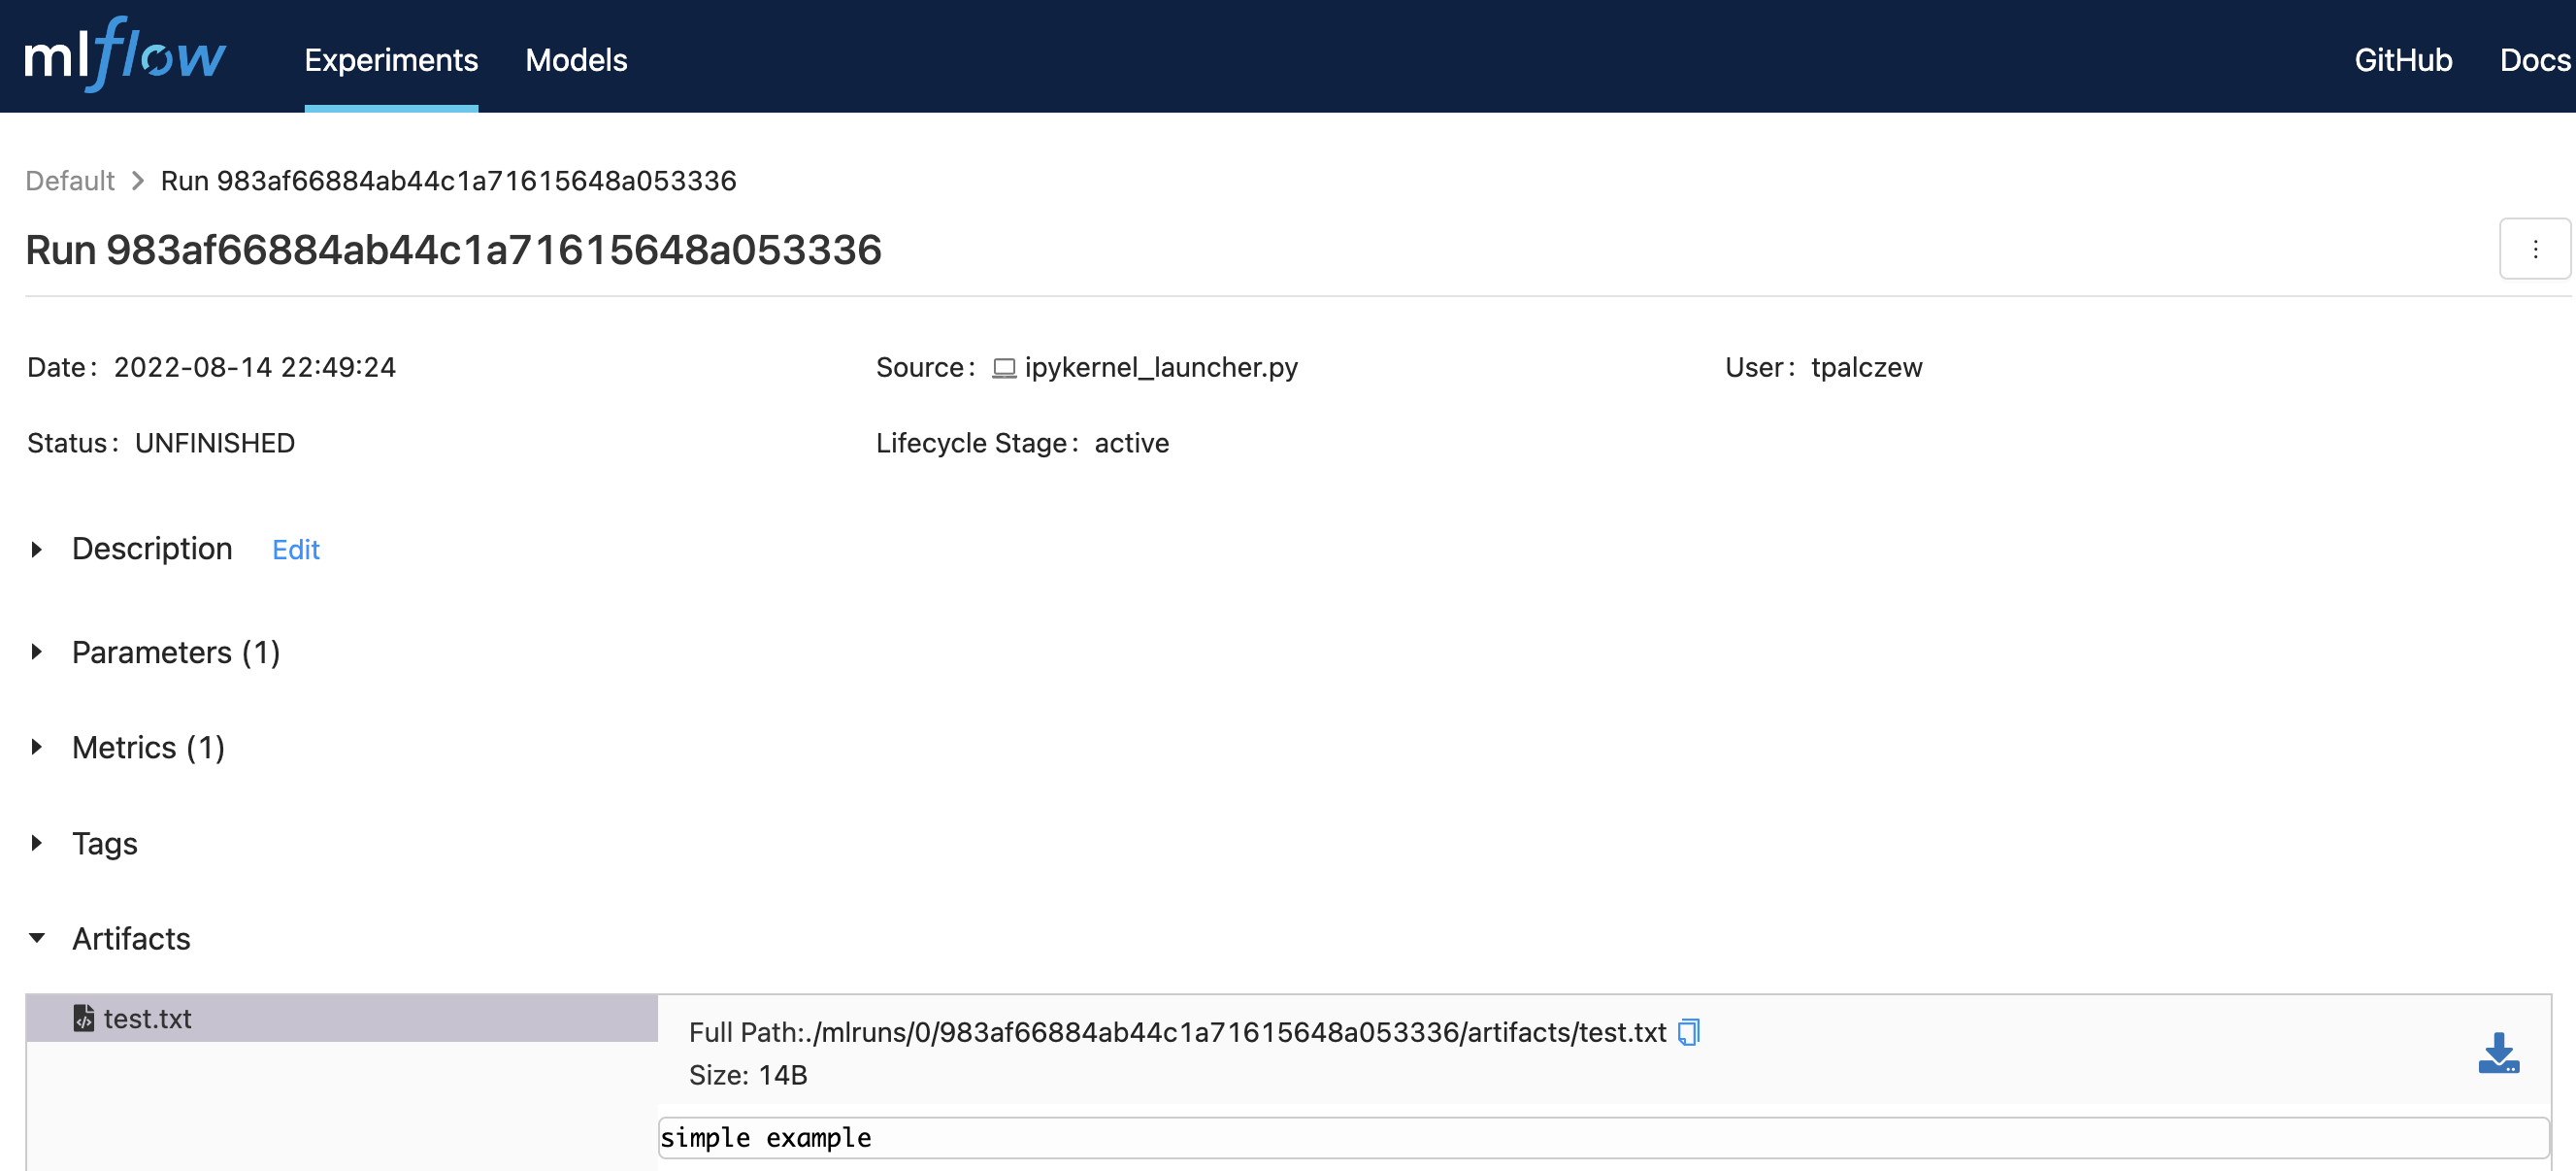

In [9]:
from IPython.display import Image
Image(filename='static/first_details.png') 

In [13]:
mlflow.end_run()

In the example above, we created a default run without providing excplicty name. Let's have a look how we can create named runs now. 
In this example, we will create experiment called "DLBook_1" and then create run in that experiment called run_1.

In [16]:
exp_id = mlflow.create_experiment("DLBook_1")

exp = mlflow.get_experiment(exp_id)

with mlflow.start_run(experiment_id = exp.experiment_id, run_name='run_1') as run:
    # logging starts here
    mlflow.set_tag('model_name', 'model1_dev')
    log_param("epochs", 30)
    log_metric("custom", 0.6)               

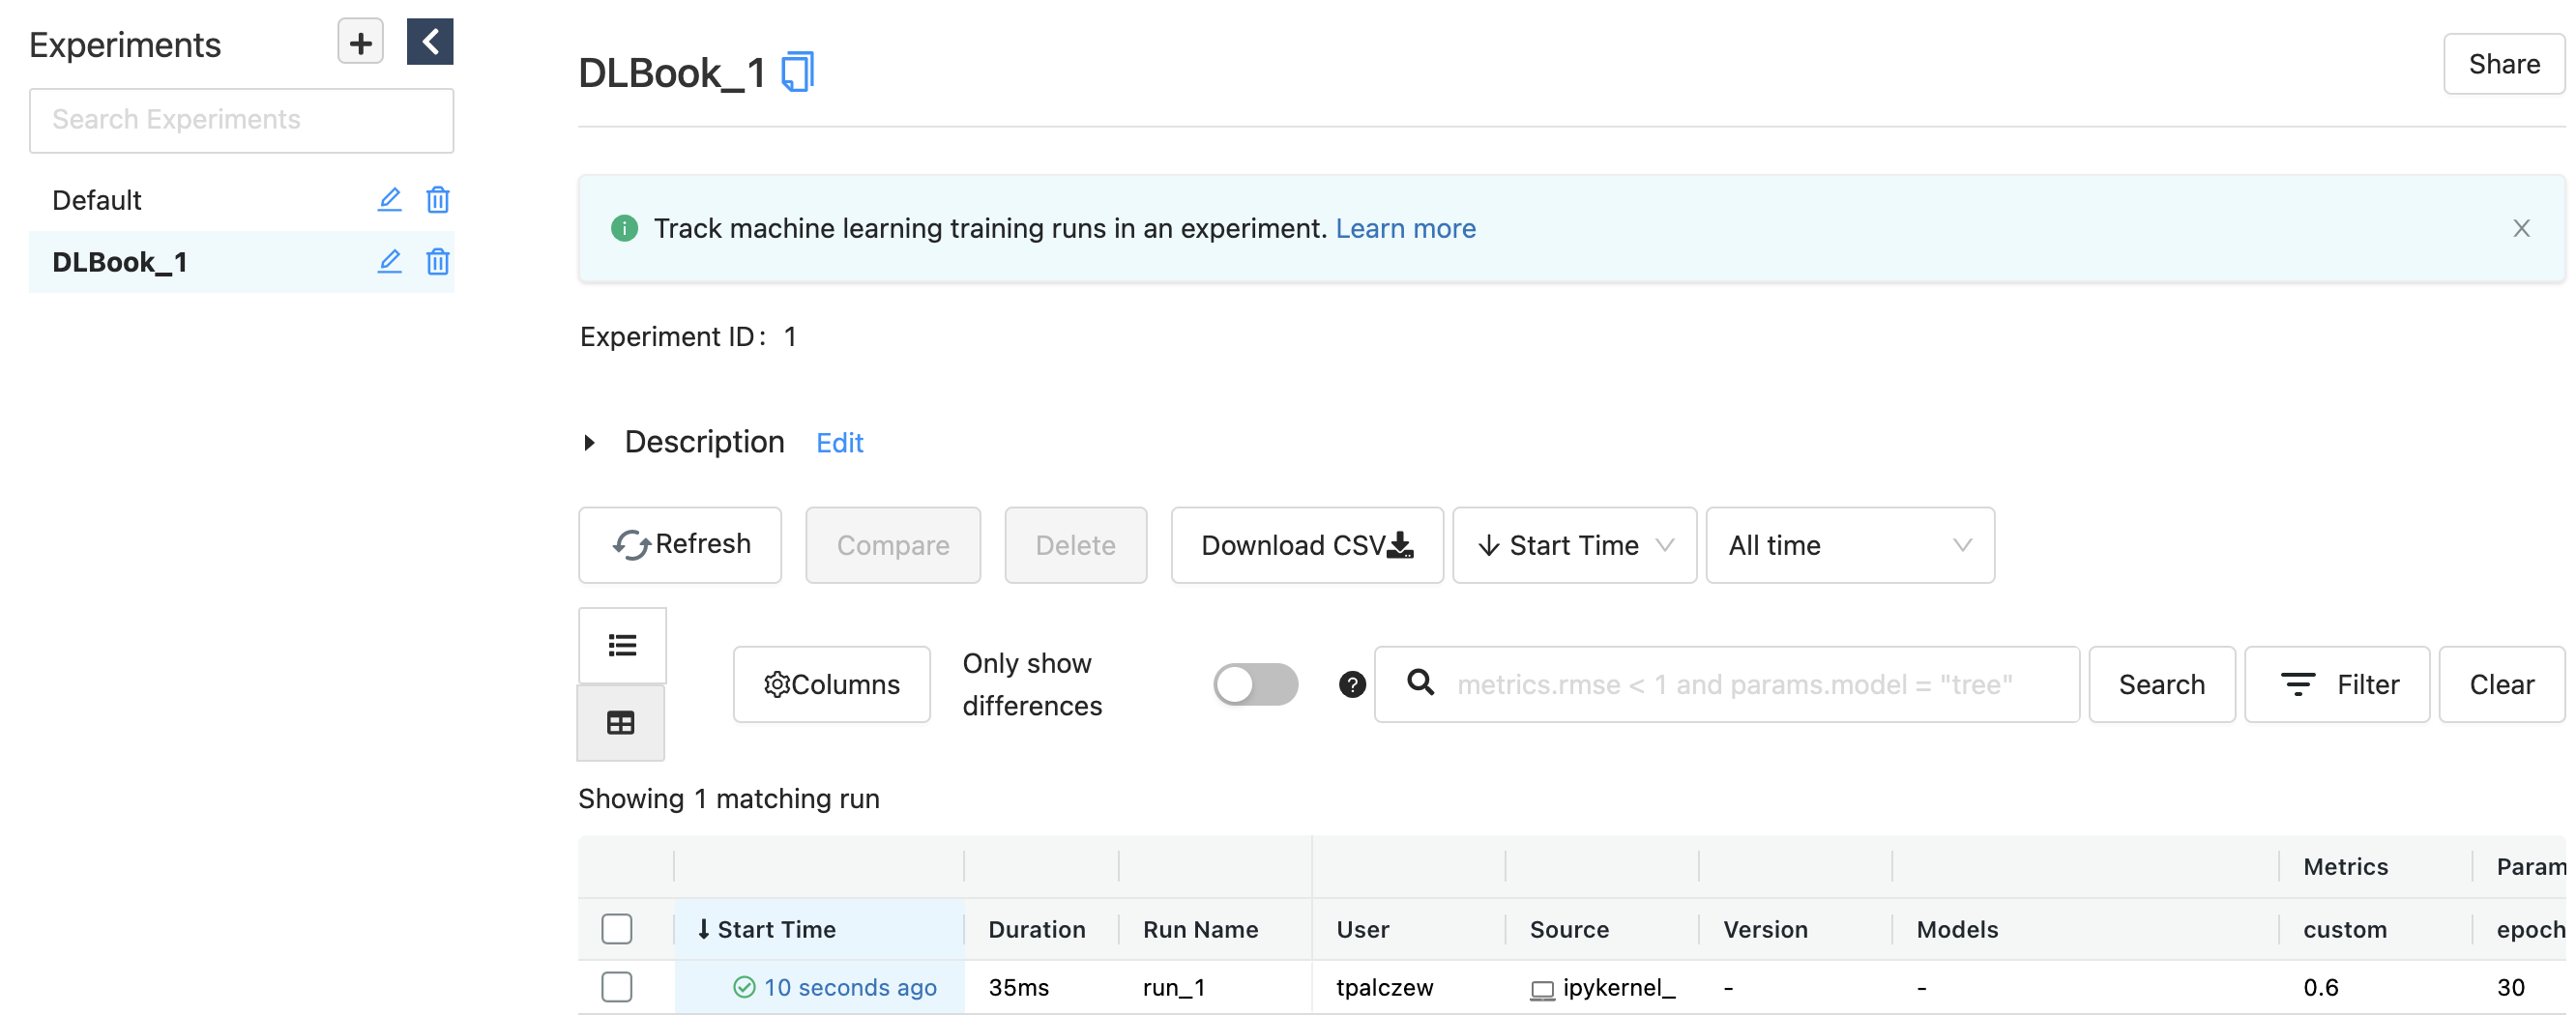

In [17]:
from IPython.display import Image
Image(filename='static/run1.png') 

MLflow allows to create child runs for your main run. It might be useful when you are working on larger projects or you are collaborating with other people. In addition, it comes handy when running hyperparameter tuning.

MlflowClient gives you needed tools to easily get information about experiments, runs, ... 

In [21]:
from mlflow.tracking import MlflowClient
client = MlflowClient()

# Get experiment ID by name 
experiment = client.get_experiment_by_name("DLBook_1").experiment_id
print(experiment)

1


In [23]:
from mlflow.utils.mlflow_tags import MLFLOW_RUN_NAME
from mlflow.utils.mlflow_tags import MLFLOW_USER

# let's create parent run "run_2"
parent_run = client.create_run(experiment_id=experiment,
                              tags={MLFLOW_RUN_NAME: "run_2", 
                                    MLFLOW_USER:"tpalczew"})

In [25]:
client.log_param(parent_run.info.run_id, "who", "parent")
client.log_param(parent_run.info.run_id, "Description", "Our main run for set of smaller runs")

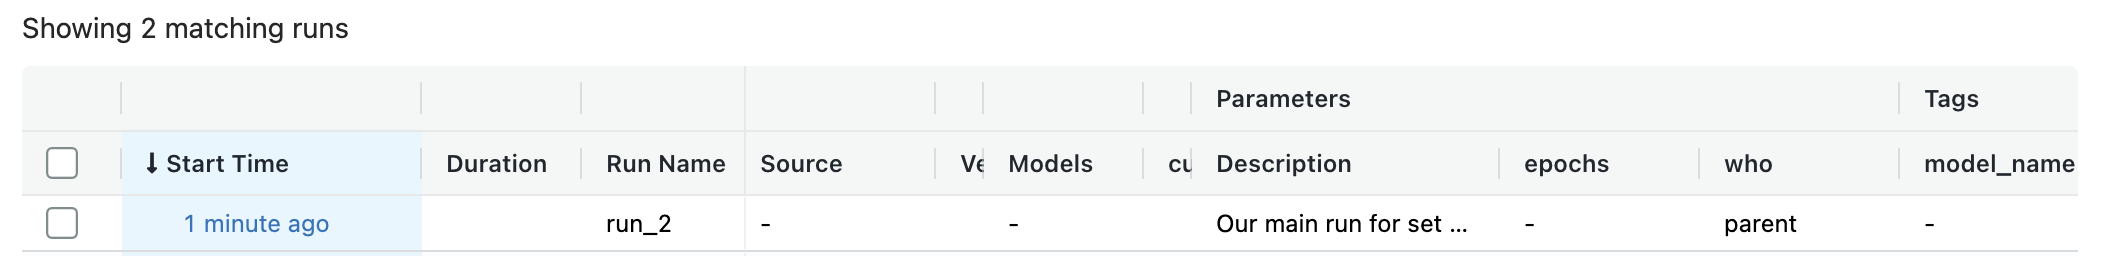

In [26]:
from IPython.display import Image
Image(filename='static/parent.png') 

and now we can create a child run 

In [28]:
from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID

child_run = client.create_run( experiment_id = experiment, 
                             tags={MLFLOW_RUN_NAME: "run_2", 
                                   MLFLOW_USER:"tpalczew", 
                                   MLFLOW_PARENT_RUN_ID: parent_run.info.run_id})

and finally we can log some information to the child run 

In [29]:
client.log_param(child_run.info.run_id, 'who', 'child')
client.log_param(child_run.info.run_id, "run_id", 'run_2_1')
client.log_param(child_run.info.run_id, "Description", 'First subrun of run_2')

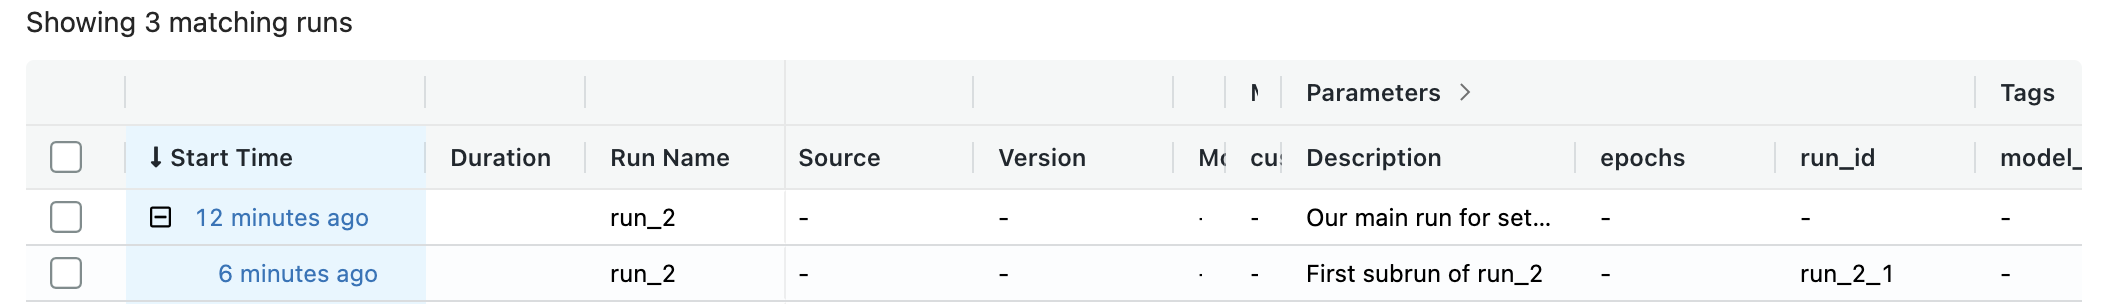

In [30]:
from IPython.display import Image
Image(filename='static/subrun.png') 

## Next, let's have a look at integration of MLflow into TF Keras project

We will again use same dataset that was used in Chapter 3 and will set a dummy keras model. 

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
# data
data = pd.read_csv("sample_google_scholar.csv")
data = data.dropna()
def convert_first_ten_characters_into_tensor(data):
    first_ten_characters = data[:10]
    converted = [ord(char)/256 for char in first_ten_characters]
    while len(converted) < 10:
        converted.append(0.0)
    return np.array(converted)
converted_affiliation = data['affiliation'].map(convert_first_ten_characters_into_tensor)
affiliation = np.vstack(converted_affiliation.values)
converted_email = data['email'].str.contains('.edu')
labels = converted_email.values
# model 
input_shape = 10
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Dense(128, activation="relu", name="layer1"),
        layers.Dense(64, activation="relu", name="layer2"),
        layers.Dense(1, activation="sigmoid", name="layer3"),
    ])
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=optimizer)
# model fit 
model.fit(affiliation, labels, batch_size=16, epochs=5, validation_split=0.2)

# mlflow integration 

with mlflow.start_run() as run:
    mlflow.keras.log_model(model, "models")


Train on 48 samples, validate on 12 samples
Epoch 1/5
48/48 [==============================] - 1s 24ms/sample - loss: 0.6920 - val_loss: 0.7105
Epoch 2/5
48/48 [==============================] - 0s 1ms/sample - loss: 0.6894 - val_loss: 0.7164
Epoch 3/5
48/48 [==============================] - 0s 1ms/sample - loss: 0.6868 - val_loss: 0.7207
Epoch 4/5
48/48 [==============================] - 0s 962us/sample - loss: 0.6858 - val_loss: 0.7162
Epoch 5/5
48/48 [==============================] - 0s 1ms/sample - loss: 0.6835 - val_loss: 0.7173
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2022-08-14 23:48:43.489688: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/lr/sp74bxw50pz1ylmkv7qtlf_m0000gp/T/tmp69shqdbp/model/data/model/assets


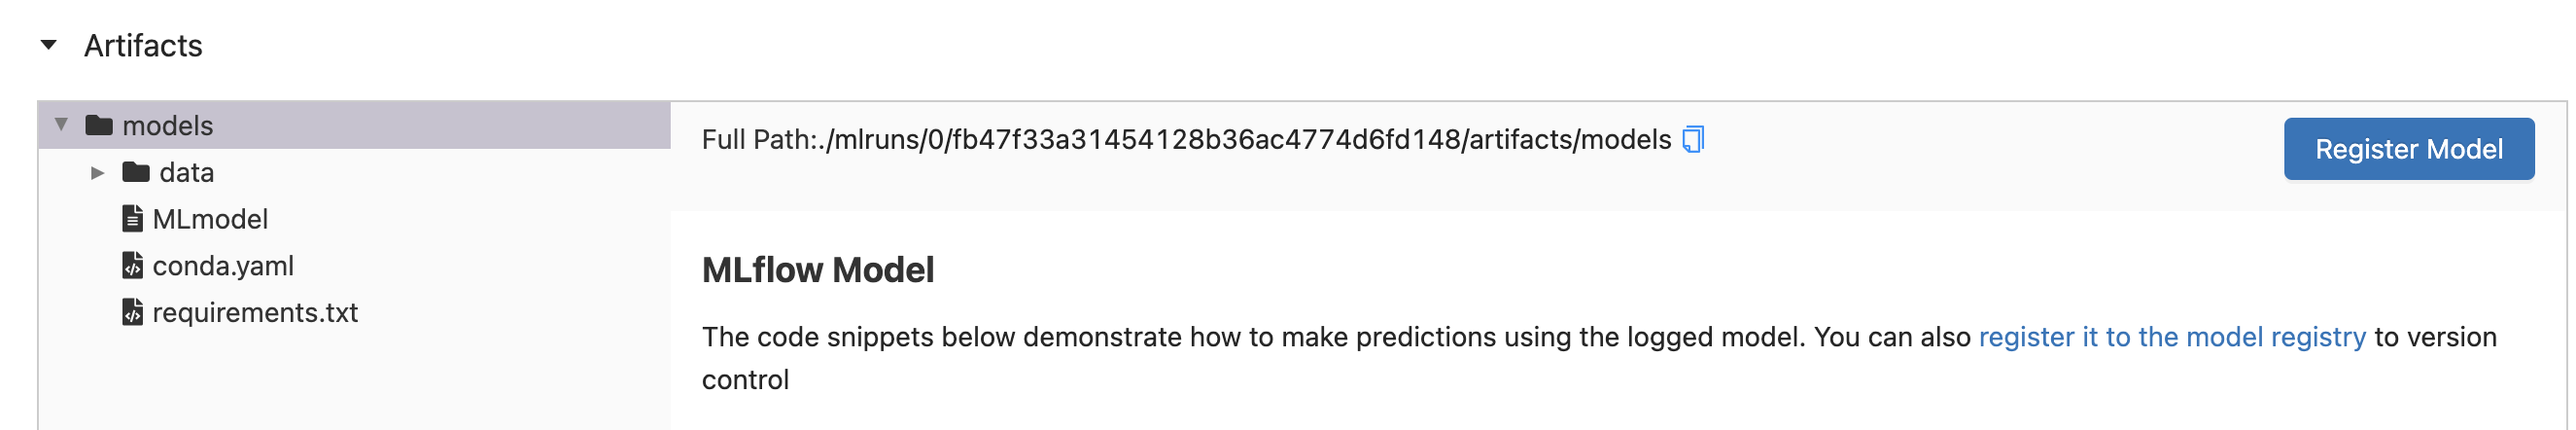

In [35]:
from IPython.display import Image
Image(filename='static/model_artifact.png') 

Worth reading: https://www.mlflow.org/docs/latest/python_api/index.html

MLflow provides APIs for logging TensorFlow, PyTorch, Keras, Onnx, and many more framework models. It is also possible to integrate MLflow into PyTroch Lighting projects as we discuss in the book. 